<a href="https://colab.research.google.com/github/ConanGuy/ESILV-S7-Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns

## Loading file

In [86]:
dfMain = pd.read_csv("sample_data/SkillCraft1_Dataset.csv", na_values=['?']).fillna(0)
# dfMain

ranks_labels = ["Bronze","Silver","Gold","Platinum","Diamond","Master","Grandmaster", "Pro"]

ranks_idx = dfMain["LeagueIndex"].unique()
ranks_idx.sort()

ranks_colors = ["#614e1a", "#b5b5bd", "#e7bd42", "#8fA290", "#70d1f4", "#ffc0cb", "#e75480", "#afafaf"]

ranks_color_per_label = {ranks_labels[i]: ranks_colors[i] for i,v in enumerate(ranks_colors)}

dfMain["RankLabel"] = dfMain[["LeagueIndex"]].apply(lambda row: ranks_labels[row["LeagueIndex"]-1], axis=1)
dfMain["RankColor"] = dfMain[["LeagueIndex"]].apply(lambda row: ranks_colors[row["LeagueIndex"]-1], axis=1)

dfMain

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,RankLabel,RankColor
0,52,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.000000,0.000000,Diamond,#70d1f4
1,55,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.000000,0.000208,Diamond,#70d1f4
2,56,4,30.0,10.0,200.0,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.000000,0.000189,Platinum,#8fA290
3,57,3,19.0,20.0,400.0,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.000000,0.000384,Gold,#e7bd42
4,58,3,32.0,10.0,500.0,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.000000,0.000019,Gold,#e7bd42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,10089,8,0.0,0.0,0.0,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000,Pro,#afafaf
3391,10090,8,0.0,0.0,0.0,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000,Pro,#afafaf
3392,10092,8,0.0,0.0,0.0,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000,Pro,#afafaf
3393,10094,8,0.0,0.0,0.0,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631,Pro,#afafaf


In [87]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data representation

## Players repartition

### Numbers of players per rank

In [88]:
dfCountPerLeague = dfMain[['LeagueIndex','RankLabel']].groupby(['LeagueIndex','RankLabel'], as_index=False).size()

fig = px.bar(dfCountPerLeague, x='RankLabel', y="size", color="RankLabel", color_discrete_sequence=ranks_colors)
fig.show()

### Percentage of players per rank

In [89]:
dfPlayersPerRank = dfMain[["LeagueIndex", "RankLabel", "RankColor"]].groupby(["LeagueIndex", "RankLabel", "RankColor"], as_index=False).size()

fig = px.pie(dfPlayersPerRank, values="size", names="RankLabel", title='Percentage of players for each rank', color="RankLabel",
             color_discrete_sequence=ranks_colors)
fig.show()

## Global stats

### HoursPerWeek per Age

In [90]:
#Age: Age of each player (integer) / HoursPerWeek: Reported hours spent playing per week (integer)
#Relation entre age et nombre d heures pasees à jouer ? 

dfHoursAvgPerAge = dfMain[['HoursPerWeek', 'Age']].where(dfMain["Age"]>0).groupby('Age', as_index=False).mean()

fig = px.bar(dfHoursAvgPerAge, x="Age", y="HoursPerWeek", color="Age")

fig.show()

### Age and TotalHours repartition

In [91]:
dfAgeAndRanks = dfMain[["RankLabel", "LeagueIndex", "Age", "TotalHours"]].sort_values("LeagueIndex")

fig =px.scatter(dfAgeAndRanks, x="TotalHours", y="Age", color="RankLabel", color_discrete_sequence=ranks_colors, range_x=[0,10000], range_y=[10,50])
fig.show()

## Stats per rank

### TotalHours per rank

In [92]:
dfHoursPerRank = dfMain[['TotalHours', 'RankLabel', 'LeagueIndex']].where(dfMain["RankLabel"] != "Pro").groupby(['RankLabel', 'LeagueIndex'], as_index=False).mean().sort_values("LeagueIndex")
# Removing pros because we do not have the hours played for them

fig = px.bar(dfHoursPerRank, x="RankLabel", y="TotalHours", 
             color="RankLabel", color_discrete_sequence=ranks_colors).update_xaxes(categoryorder="total ascending")
fig.show()

### APM  per rank

In [93]:
#pour avoir des resultats plus étendues, on peut étudier les heures de jeux à la semaine et à l'année
dfMain["WeeksPlayed"] = dfMain["TotalHours"]/dfMain["HoursPerWeek"]
dfMain["YearsPlayed"] = ((dfMain["TotalHours"]/dfMain["HoursPerWeek"])//52)

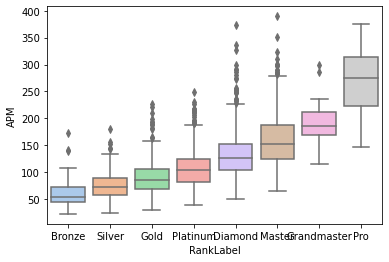

In [94]:
ax = sns.boxplot(x="RankLabel", y="APM", data=dfMain.sort_values("LeagueIndex"), palette="pastel")

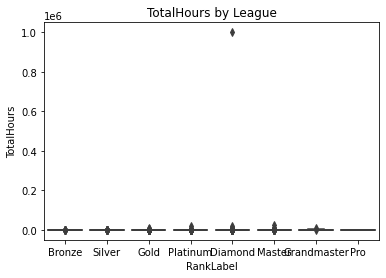

In [95]:

plt1 = sns.boxplot(x = "RankLabel", y = "HoursPerWeek", data = dfMain.sort_values("LeagueIndex")).set_title("HoursPerWeek by League")
plt2 = sns.boxplot(x = "RankLabel", y = "TotalHours", data = dfMain.sort_values("LeagueIndex")).set_title("TotalHours by League")

### NumberOfPACs per rank

In [96]:
dfPACsPerRank = dfMain[['RankLabel', 'LeagueIndex', "NumberOfPACs"]].groupby(['RankLabel']).mean().reset_index().sort_values("LeagueIndex")
fig = px.bar(dfPACsPerRank, x="NumberOfPACs", y="RankLabel", orientation='h', color="RankLabel",
             color_discrete_sequence=ranks_colors)
fig.show()

### NumberOfPACs per AssignToHotkeys for each rank

In [97]:
df = dfMain[["RankLabel", "LeagueIndex", "AssignToHotkeys", "NumberOfPACs"]].sort_values("LeagueIndex")

px.scatter(df, y="AssignToHotkeys", x="NumberOfPACs",
           animation_frame="RankLabel",
           color="RankLabel", color_discrete_sequence=ranks_colors)

# Scikit-lear part

In [98]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn import svm

In [99]:
dFS= pd.read_csv("sample_data/SkillCraft1_Dataset.csv", na_values=['?']).fillna(0)
raw_df = pd.read_csv("sample_data/SkillCraft1_Dataset.csv", na_values=['?'], skiprows=2, header=None).fillna(0)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
data

array([[5.5000e+01, 5.0000e+00, 2.3000e+01, ..., 2.0757e-04, 5.6000e+01,
        4.0000e+00],
       [5.7000e+01, 3.0000e+00, 1.9000e+01, ..., 3.8358e-04, 5.8000e+01,
        3.0000e+00],
       [6.0000e+01, 2.0000e+00, 2.7000e+01, ..., 0.0000e+00, 6.1000e+01,
        1.0000e+00],
       ...,
       [1.0084e+04, 8.0000e+00, 0.0000e+00, ..., 9.9161e-05, 1.0089e+04,
        8.0000e+00],
       [1.0090e+04, 8.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0092e+04,
        8.0000e+00],
       [1.0094e+04, 8.0000e+00, 0.0000e+00, ..., 6.3141e-04, 1.0095e+04,
        8.0000e+00]])

In [100]:
X=data
Y=target
print(X.shape)
X_train, X_test,Y_train,Y_test=train_test_split(X, Y, test_size= 0.33)
print(Y_train)

(1697, 22)
[19. 24. 23. ... 25. 21. 18.]


In [101]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [102]:
reg = svm.SVR()
reg.fit(X_train,Y_train)
reg.predict(X_test)
#print(reg.score(X_train,Y_train))
score=reg.score(X_test,Y_test) #x test refait la prediction et la compare à y test

In [103]:
reg.get_params() 

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}